In [1]:
import pandas as pd
import os
import json

import pickle
from kg import KnowledgeGraph


/home/kaize/Downloads/Master_Study_Research-Project-Graph-in-Graph-Models-for-Rare-Disease-Detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = os.environ.get('DATA_DIR', './Data')
output_dir = os.environ.get('OUTPUT_DIR', './Output')

In [3]:
## Add node indices
## nodes_df: Dataframe containing node information with columns: node_idx, node_id, node_type
## relations_df: Dataframe containing relation information with columns: source ID/type, target ID/type

def add_node_indices(nodes_df, relations_df):
    """
    Add node indices from nodes dataframe to relations dataframe based on ID and type matching.
    
    Args:
    	nodes_df (pd.DataFrame): Dataframe containing node information with columns: node_idx, node_id, node_type
    	relations_df (pd.DataFrame): Dataframe containing relation information with columns: x_id, x_type, y_id, y_type
   
    Returns:
    	pd.DataFrame: Filtered relations dataframe with added x_idx, y_idx, and included columns
    """
    # Create a copy of the relations dataframe to avoid modifying the original
    result_df = relations_df.copy()
    
    # Convert node_id to string type in nodes_df for consistent matching
    nodes_df = nodes_df.copy()
    nodes_df['node_id'] = nodes_df['node_id'].astype(str)
    
    # Convert x_id and y_id to string type in relations_df
    result_df['x_id'] = result_df['x_id'].astype(str)
    result_df['y_id'] = result_df['y_id'].astype(str)
    
    # Create a mapping dictionary from (node_id, node_type) to node_idx
    node_mapping = pd.Series(
        nodes_df.node_idx.values,
        index=pd.MultiIndex.from_arrays([nodes_df.node_id, nodes_df.node_type])
    ).to_dict()
    
    # Create a function to safely get mapping value
    def get_mapping(row, id_col, type_col):
        key = (row[id_col], row[type_col])
        return node_mapping.get(key)
    
    # Add x_idx column by mapping (x_id, x_type)
    result_df['x_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'x_id', 'x_type'), 
        axis=1
    )
    
    # Add y_idx column by mapping (y_id, y_type)
    result_df['y_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'y_id', 'y_type'), 
        axis=1
    )
    
    # Check if both indices are valid (not NaN) and add 'included' column
    result_df['included'] = result_df['x_idx'].notna() & result_df['y_idx'].notna()
    
    # Filter rows where both x_idx and y_idx are not NaN
    result_df = result_df[result_df['included']].copy()
    
    # Convert x_idx and y_idx to integers
    result_df['x_idx'] = result_df['x_idx'].astype(int)
    result_df['y_idx'] = result_df['y_idx'].astype(int)
    
    return result_df


data_dir = os.environ.get('DATA_DIR', './Data')
output_dir = os.environ.get('OUTPUT_DIR', './Output')

df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')
print("Loading HPO to index dictionary...")

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/hpo_to_idx_dict_8.9.21_kg.pkl', 'rb') as f:
    hpo_to_idx_dict = pickle.load(f)

print("Loading Genes to index dictionary...")
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/ensembl_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    genes = pickle.load(file)

with open(f'{data_dir}/preprocess/orphanet/orphanet_to_mondo_dict.pkl', 'rb') as file:
        orphanet_to_mondo_dict = pickle.load(file)

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/mondo_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    mondo_to_idx_dict = pickle.load(file)

# create_nodes_pkl(data_dir)
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl', 'rb') as file:
    nodes = pickle.load(file)

Loading HPO to index dictionary...
Loading Genes to index dictionary...


/tmp/ipykernel_1575257/2845939711.py:66: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')
/tmp/ipykernel_1575257/2845939711.py:84: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  nodes = pickle.load(file)


In [4]:
# The nodes_8.9.21_kg.pkl file contains node information with columns: node_idx, node_id, node_type
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl', 'rb') as file:
    nodes = pickle.load(file)

print("\nFirst 5 rows of the data:")
print(nodes.head(5),"\n")
print("there are:",nodes.shape[0],"of nodes \n")
print(nodes['node_type'].value_counts())


First 5 rows of the data:
   node_idx node_id     node_type        node_name node_source old_node_name
0         0    9796  gene/protein  ENSG00000168490        NCBI        PHYHIP
1         1    7918  gene/protein  ENSG00000204438        NCBI        GPANK1
2         2    8233  gene/protein  ENSG00000169249        NCBI         ZRSR2
3         3    4899  gene/protein  ENSG00000106459        NCBI          NRF1
4         4    5297  gene/protein  ENSG00000241973        NCBI         PI4KA 

there are: 105220 of nodes 

node_type
biological_process    28642
gene/protein          21610
disease               21233
effect/phenotype      15874
molecular_function    11169
cellular_component     4176
pathway                2516
Name: count, dtype: int64


/tmp/ipykernel_1575257/2073029274.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  nodes = pickle.load(file)


In [5]:
# the kg_giant_orphanet.csv file contains the relationships between nodes with columns
# this is the predefined relationships between nodes
df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')

print("\nFirst 5 rows of relationships:")
print(df.head(5), "\n")
print("there are:",df.shape[0],"of relationships \n")
print(df['relation'].value_counts())

/tmp/ipykernel_1575257/2787391124.py:3: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')



First 5 rows of relationships:
          relation display_relation  x_id        x_type  x_name x_source  \
0  protein_protein              ppi  9796  gene/protein  PHYHIP     NCBI   
1  protein_protein              ppi  7918  gene/protein  GPANK1     NCBI   
2  protein_protein              ppi  8233  gene/protein   ZRSR2     NCBI   
3  protein_protein              ppi  4899  gene/protein    NRF1     NCBI   
4  protein_protein              ppi  5297  gene/protein   PI4KA     NCBI   

    y_id        y_type  y_name y_source  
0  56992  gene/protein   KIF15     NCBI  
1   9240  gene/protein   PNMA1     NCBI  
2  23548  gene/protein   TTC33     NCBI  
3  11253  gene/protein  MAN1B1     NCBI  
4   8601  gene/protein   RGS20     NCBI   

there are: 5471882 of relationships 

relation
drug_drug                     2672628
protein_present_anatomy       1518203
protein_protein                321075
disease_phenotype_positive     204779
protein_bioprocess             144805
disease_protein     

In [6]:
# View some HPO indices
print("Sample HPO indices:")
print(list(hpo_to_idx_dict.items())[:5])

# View some gene indices
print("\nSample gene indices:")
print(list(genes.items())[:5])

# View some disease indices
print("\nSample disease indices:")
print(list(mondo_to_idx_dict.items())[:5])

Sample HPO indices:
[('HP:0002240', 14012), ('HP:0001254', 14013), ('HP:0010547', 14014), ('HP:0001252', 14015), ('HP:0001250', 14016)]

Sample gene indices:
[('ENSG00000168490', 0), ('ENSG00000204438', 1), ('ENSG00000169249', 2), ('ENSG00000106459', 3), ('ENSG00000241973', 4)]

Sample disease indices:
[('13924', 19687), ('11160', 19688), ('8099', 19689), ('14854', 19690), ('33202', 19691)]


In [8]:
## enriched information about the nodes and their relationships
## output: result.csv, after mapping the relationship into nodes, we built the knowledge graph
import os

# This creates the directory if it doesn't exist
# exist_ok=True prevents an error if the folder already exists
os.makedirs(output_dir, exist_ok=True)

# Now your original command will work
result.to_csv(f'{output_dir}/result.csv', index=False)


Loading nodes from ./Data/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl
Loaded 105,220 nodes
Node columns: ['node_idx', 'node_id', 'node_type', 'node_name', 'node_source', 'old_node_name']
Loading relationships from Output/result.csv
Processed 1 chunks (105,220 rows)
Current graph size: 105,220 nodes, 105,220 edges
Number of node types: 7


/home/kaize/Downloads/Master_Study_Research-Project-Graph-in-Graph-Models-for-Rare-Disease-Detection/kg.py:776: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk_num, chunk in enumerate(pd.read_csv(filepath, chunksize=chunksize)):


Processed 11 chunks (1,157,420 rows)
Current graph size: 105,220 nodes, 1,095,378 edges
Number of node types: 7

Finished loading 1,157,420 relationship rows
Total nodes from pickle file: 105,220
Total unique node types: 7

=== Knowledge Graph Summary ===
Nodes: 105,220
Edges: 1,095,378
Density: 0.000198
Average Degree: 20.82
Connected Components: 56

Node Types Distribution:
  biological_process: 28,642
  cellular_component: 4,176
  disease: 21,233
  effect/phenotype: 15,874
  gene/protein: 21,610
  molecular_function: 11,169
  pathway: 2,516

Edge Types Distribution:
  bioprocess_bioprocess: 52,886
  cellcomp_cellcomp: 4,845
  disease_disease: 35,167
  disease_phenotype_negative: 1,483
  disease_phenotype_positive: 204,779
  disease_protein: 86,299
  molfunc_molfunc: 13,574
  pathway_pathway: 2,535
  phenotype_phenotype: 21,925
  phenotype_protein: 10,518
  protein_bioprocess: 144,805
  protein_cellcomp: 83,402
  protein_molfunc: 69,530
  protein_pathway: 42,646
  protein_protein: 32

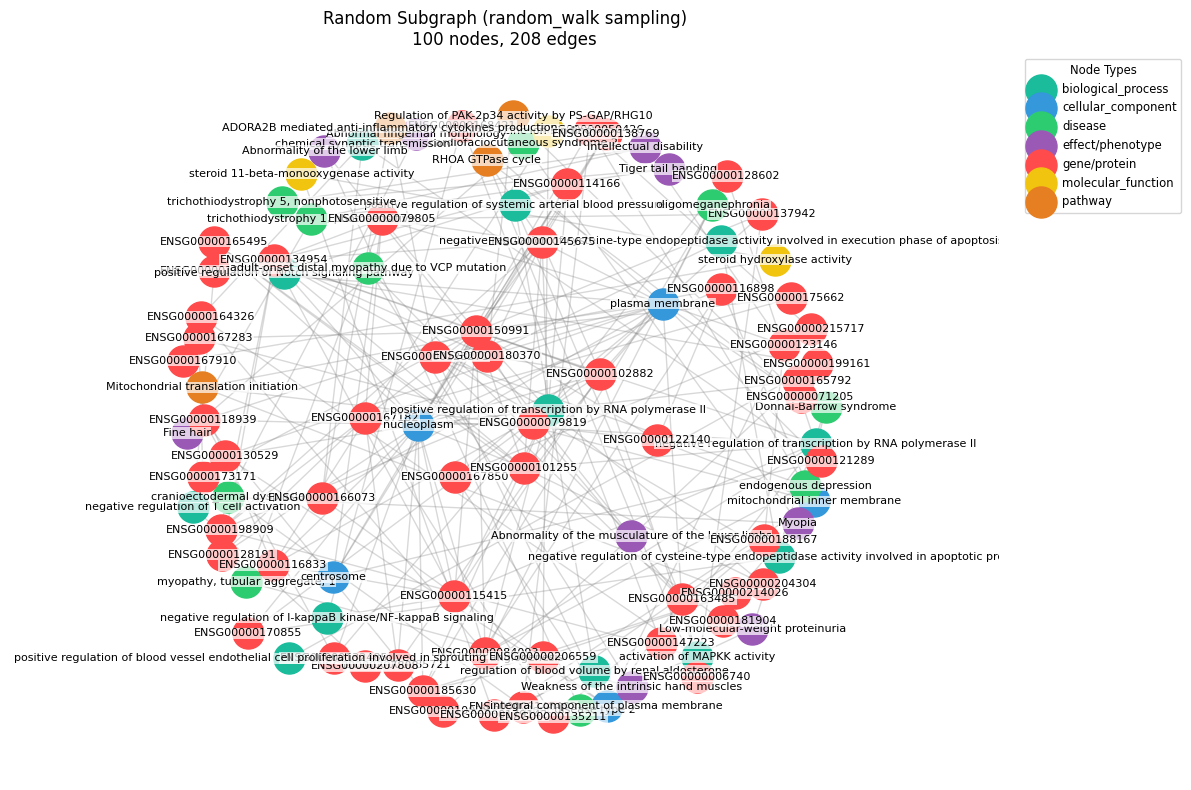

In [9]:
## Generate and construct the knowledge graph

## Initialize KG
kg = KnowledgeGraph()

## Chucksize is the size of knowledge graph data to be loaded at once
kg.create_from_csv(
    filepath=f'./{output_dir}/result.csv',
    nodes_filepath = f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl',
    chunksize=105220,  # Adjust based on your memory constraints
    show_progress=True
)
# Save the graph
## This is the knowledge graph
kg.save_graph(f'{output_dir}/my_graph_ids.graphml')


# double check the KG 
subgraph = kg.plot_random_subgraph(num_nodes=100, method='random_walk')

In [10]:
# # # Initialize KG
kg = KnowledgeGraph()
kg.load_graph(f'{output_dir}/my_graph_ids.graphml')

In [11]:
# WORKING with PATINIET DATA
print('Loading and processing patient data...')
file_path = f'{data_dir}/patients/simulated_patients/disease_split_val_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    val_data = [json.loads(line) for line in f]

file_path = f'{data_dir}/patients/simulated_patients/disease_split_train_sim_patients_8.9.21_kg.txt'  # train data!!!!
with open(file_path, 'r') as f:
    train_data = [json.loads(line) for line in f]


## Map the phenotype to the index
val_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in val_data]
train_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in train_data]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(val_patients_phenotypes_list, f)

## Map genes to index
val_patients_genes = [
    [genes[g] for g in p['true_genes']]
    for p in val_data
]


# WORKING with PATINIET DATA
print('Loading and processing patient data...')
file_path = f'{data_dir}/patients/simulated_patients/disease_split_val_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    val_data = [json.loads(line) for line in f]

file_path = f'{data_dir}/patients/simulated_patients/disease_split_train_sim_patients_8.9.21_kg.txt'  # train data!!!!
with open(file_path, 'r') as f:
    train_data = [json.loads(line) for line in f]


## Map the phenotype to the index
val_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in val_data]
train_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in train_data]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(val_patients_phenotypes_list, f)

## Map genes to index
val_patients_genes = [[genes[g] for g in p['true_genes']] for p in val_data]
train_patients_genes = [[genes[g] for g in p['true_genes']] for p in train_data]

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(train_patients_phenotypes_list, f)


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_genes.pkl', 'wb') as f:
    pickle.dump(val_patients_genes, f)

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_genes.pkl', 'wb') as f:
    pickle.dump(train_patients_genes, f)

## Map the disease to the index
val_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in val_data]
train_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in train_data]

# Save the list to a pickle file
with open(f'{output_dir}/val_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(val_all_candidate_genes, f)

# Save the list to a pickle file
with open(f'{output_dir}/train_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(train_all_candidate_genes, f)

print("Saved patient_training and validation data")

## process test data
file_path = f'{data_dir}/patients/mygene2_patients/mygene2_5.7.22.txt'  # val data!!!!

with open(file_path, 'r') as f:
    test_data = [json.loads(line) for line in f]
    
test_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in test_data]


# Save the list to a pickle file
with open(f'{output_dir}/test_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(test_patients_phenotypes_list, f)

test_patients_genes = [[genes[g] for g in p['true_genes']] for p in test_data]

# Save the list to a pickle file
with open(f'{output_dir}/test_patients_genes.pkl', 'wb') as f:
    pickle.dump(test_patients_genes, f)


test_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in test_data]

# Save the list to a pickle file
with open(f'{output_dir}/test_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(test_all_candidate_genes, f)

print("Saved patient_test data")

Loading and processing patient data...
Loading and processing patient data...
Saved patient_training and validation data
Saved patient_test data


In [12]:
# What in training data 
# True genes that cause specific diseases
# True symptoms
# True age of conset
# All candidate genes

train_data[0]

{'true_genes': ['ENSG00000146085'],
 'age': 'Onset_Infant',
 'positive_phenotypes': ['HP:0000124',
  'HP:0001249',
  'HP:0001254',
  'HP:0001259',
  'HP:0001252',
  'HP:0001510',
  'HP:0002017',
  'HP:0004374',
  'HP:0410042',
  'HP:0001903',
  'HP:0100806',
  'HP:0001279',
  'HP:0000712',
  'HP:0100739',
  'HP:0031009',
  'HP:0001363',
  'HP:0001360'],
 'negative_phenotypes': {'HP:0000083': ['init_phenotypes'],
  'HP:0001019': ['phenotype_distractor.9'],
  'HP:0002716': ['phenotype_distractor.9'],
  'HP:0002240': ['phenotype_distractor.9'],
  'HP:0000643': ['noisy_phenotype'],
  'HP:0001369': ['noisy_phenotype'],
  'HP:0008226': ['noisy_phenotype']},
 'n_distractor_genes': 11,
 'distractor_genes': ['ENSG00000143727',
  'ENSG00000014216',
  'ENSG00000158352',
  'ENSG00000105664',
  'ENSG00000197915',
  'ENSG00000157766',
  'ENSG00000188994',
  'ENSG00000095464',
  'ENSG00000132155',
  'ENSG00000152457',
  'ENSG00000168056'],
 'dropout_phenotypes': {'positive_phenotypes': ['HP:0001733',

In [13]:
# What in training data 
# True genes that cause specific diseases
# True symptoms
# True age of conset
# All candidate genes

train_data[0]

{'true_genes': ['ENSG00000146085'],
 'age': 'Onset_Infant',
 'positive_phenotypes': ['HP:0000124',
  'HP:0001249',
  'HP:0001254',
  'HP:0001259',
  'HP:0001252',
  'HP:0001510',
  'HP:0002017',
  'HP:0004374',
  'HP:0410042',
  'HP:0001903',
  'HP:0100806',
  'HP:0001279',
  'HP:0000712',
  'HP:0100739',
  'HP:0031009',
  'HP:0001363',
  'HP:0001360'],
 'negative_phenotypes': {'HP:0000083': ['init_phenotypes'],
  'HP:0001019': ['phenotype_distractor.9'],
  'HP:0002716': ['phenotype_distractor.9'],
  'HP:0002240': ['phenotype_distractor.9'],
  'HP:0000643': ['noisy_phenotype'],
  'HP:0001369': ['noisy_phenotype'],
  'HP:0008226': ['noisy_phenotype']},
 'n_distractor_genes': 11,
 'distractor_genes': ['ENSG00000143727',
  'ENSG00000014216',
  'ENSG00000158352',
  'ENSG00000105664',
  'ENSG00000197915',
  'ENSG00000157766',
  'ENSG00000188994',
  'ENSG00000095464',
  'ENSG00000132155',
  'ENSG00000152457',
  'ENSG00000168056'],
 'dropout_phenotypes': {'positive_phenotypes': ['HP:0001733',

In [14]:
## To map the local id to global id
train_nx_subgraph = []
train_pg_subgraph = []

for i in range(len(train_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in train_patients_phenotypes_list[i] + train_all_candidate_genes[i] + train_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in train_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    train_nx_subgraph.append(subgraph)
    train_pg_subgraph.append(pg_graph)

In [15]:
print(train_pg_subgraph[0])
## x = 58 nodes, there are 7 types of nodes
## edge_index: 196 connections between nodes
## edge_attr: 15 types of the connections
## There are 36224 patients in the training data

Data(
  x=[58, 7],
  edge_index=[2, 196],
  edge_attr=[196, 15],
  node_mapping={
    12554=0,
    14923=1,
    20079=2,
    729=3,
    20698=4,
    51614=5,
    14430=6,
    10335=7,
    14594=8,
    15322=9,
    27869=10,
    14015=11,
    15726=12,
    14138=13,
    12868=14,
    1604=15,
    16340=16,
    15567=17,
    14341=18,
    2448=19,
    15279=20,
    19172=21,
    69662=22,
    60332=23,
    14434=24,
    10649=25,
    14120=26,
    14013=27,
    26552=28,
    15274=29,
    14231=30,
    12980=31,
    19829=32,
    4536=33,
    2491=34,
    24307=35,
    54643=36,
    20953=37,
    5925=38,
    3170=39,
    9967=40,
    5784=41,
    25375=42,
    28869=43,
    23595=44,
    54520=45,
    14012=46,
    988=47,
    27771=48,
    26446=49,
    1591=50,
    14744=51,
    51663=52,
    15350=53,
    19674=54,
    395=55,
    14016=56,
    14042=57,
  },
  node_names=[58],
  original_ids=[58],
  node_type_mapping={
    biological_process=0,
    cellular_component=1,
    disease=

In [16]:
val_nx_subgraph = []
val_pg_subgraph = []

for i in range(len(val_patients_phenotypes_list)):

    # Without patients
    subgraph = kg.create_subgraph([str(n) for n in val_patients_phenotypes_list[i]+ val_all_candidate_genes[i]+ val_patients_genes[i]], true_gene_ids = [str(k) for k in val_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    val_nx_subgraph.append(subgraph)
    val_pg_subgraph.append(pg_graph)

In [17]:
test_nx_subgraph = []
test_pg_subgraph = []

for i in range(len(test_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in test_patients_phenotypes_list[i] + test_all_candidate_genes[i] + test_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in test_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    test_nx_subgraph.append(subgraph)
    test_pg_subgraph.append(pg_graph)

In [19]:
import os
import pickle

# 1. Define the specific directory you want
# I am using the full path you provided to avoid any confusion
save_dir = '/home/kaize/Downloads/Master_Study_Research-Project-Graph-in-Graph-Models-for-Rare-Disease-Detection/saved_data_pkl'

# 2. Create the directory if it doesn't exist (CRITICAL STEP)
# Without this, the 'open' command will fail
os.makedirs(save_dir, exist_ok=True)

# 3. Save the files into that specific directory
print("Saving training data...")
with open(f'{save_dir}/train_pg_subgraph.pkl', 'wb') as f:
    pickle.dump(train_pg_subgraph, f)

print("Saving validation data...")
with open(f'{save_dir}/val_pg_subgraph.pkl', 'wb') as f:
    pickle.dump(val_pg_subgraph, f)

print("Saving test data...")
with open(f'{save_dir}/test_pg_subgraph.pkl', 'wb') as f:
    pickle.dump(test_pg_subgraph, f)

print(f"✅ All files successfully saved to: {save_dir}")

Saving training data...
Saving validation data...
Saving test data...
✅ All files successfully saved to: /home/kaize/Downloads/Master_Study_Research-Project-Graph-in-Graph-Models-for-Rare-Disease-Detection/saved_data_pkl
